In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.font_manager import FontProperties

import h5py
import os
from sklearn.manifold import TSNE
import numpy as np
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from collections import Counter
import pandas as pd

# load topic / terms
data_root = '/mnt/msd/meta_data/'
task_fn = {
    'artist_tag': data_root + 'artist_tag_50_plsa_intrsc.dat.gz',
    'bpm': data_root + 'bpm_50_gmm_intrsc.dat.gz',
    'cdr_tag': data_root + 'cdr_tag_50_intersc.dat.gz',
    'lyrics': data_root + 'lyrics_50_plsa_intersc.dat.gz',
    'pref': data_root + 'pref_50_plsa_intrsc.dat.gz',
    'tag': data_root + 'msd_tag_50_plsa_intrsc.dat.gz',
    'year': data_root + 'year_50_gmm_intrsc.dat.gz'
}

task_term_key = {
    'artist_tag': 'tags',
    'bpm': 'factor_labels',
    'cdr_tag': 'uids',
    'lyrics': 'uids',
    'pref': 'uids',
    'tag': 'uids',
    'year': 'factor_labels'
}

F = joblib.load('/mnt/msd/meta_data/artist_factor_map_intrsc2.dat.gz')
artists = F[0]
factors = F[1]

topic_terms = {}
meta_data = {}
for k, v in task_fn.iteritems():
    meta_data[k] = joblib.load(v)
    if k != 'bpm' and k != 'year':
        topic_terms[k] = [
            [meta_data[k][task_term_key[k]][jj] for jj in j[::-1][:15]]
            for j in np.argsort(meta_data[k]['term_factors'], axis=1)
        ]
    else:
        topic_terms[k] = meta_data[k]['factor_labels']

In [139]:
# load target feature
# fn = '/mnt/bulk2/exp_res/features/31/conv_2d_tag_pref_bpm_lyrics_cdr_tag_artist_tag_year_50_intersc_b2_run31_GTZAN_feature.h5'
# fn = '/mnt/bulk2/exp_res/features/42/conv_2d_year_pref_tag_lyrics_artist_tag_50_intersc_bfc_run42_GTZAN_feature.h5'
fn = '/mnt/bulk2/exp_res/features/54/conv_2d_year_bpm_pref_tag_artist_tag_50_intersc_b6_run54_GTZAN_feature.h5'
hf = h5py.File(fn)

## Get 2D Coordinates w/ TSNE

In [140]:
tsne = TSNE(n_components=2)
X = np.concatenate([v[:] for k, v in hf['X'].iteritems()],axis=1)
x = tsne.fit_transform(X)

## Get label from eval. dataset

In [141]:
L = [hf['labels'][l.item()] for l in hf['y'][:]]
Y = hf['y'][:]

In [289]:
def draw_inset(x, Y, ax, target_task, target_zoom_area, colors, zoom=6, loc=2, mark_inset_loc=(3, 4)):
    global hf, topic_terms
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom-factor: 2.5, location: upper-left
    x1, x2, y1, y2 = target_zoom_area1 # specify the limits
    axins.set_xlim(x1, x2) # apply the x-limits
    axins.set_ylim(y1, y2) # apply the y-limits
    axins.set_title(target_task.title())
    axins.patch.set_alpha(0.9)
    
    font = FontProperties()
    font.set_weight('bold')
    font.set_size('large')
    for i, xx, yy in zip(range(len(x)), x, Y.astype(int).ravel().tolist()):
        # get topic term
        # -- get topic
        topic = np.argmax(hf['Z'][target_task][i])
        top_topic_term = topic_terms[target_task][topic][0]
        if target_task == 'bpm':
            top_topic_term = '{:.2f}'.format(top_topic_term)
        elif target_task == 'year':
            top_topic_term = '{:d}'.format(int(top_topic_term))
        axins.text(xx[0], xx[1], top_topic_term, color=colors[yy], clip_on=True, fontproperties=font)

    plt.yticks(visible=False)
    plt.xticks(visible=False)
    mark_inset(
        ax, axins, loc1=mark_inset_loc[0],
        loc2=mark_inset_loc[1], fc="none", ec="0.5"
    )

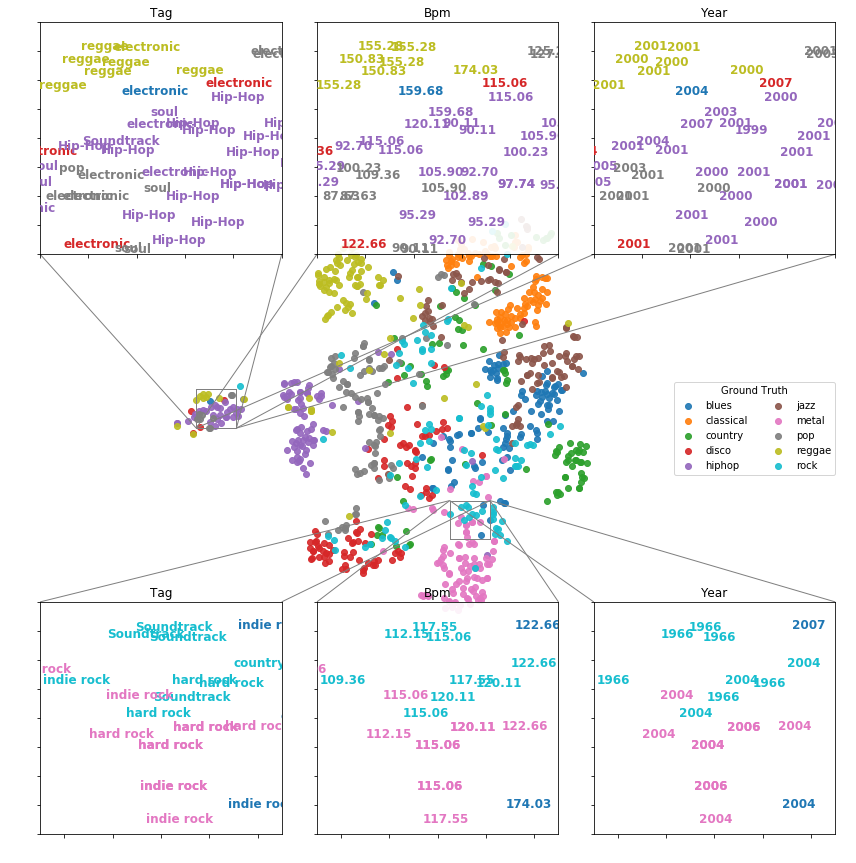

In [299]:
colors = plt.cm.Vega10(np.linspace(0., 1., 10))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_xlim(-100, 100)
ax.set_ylim(-90, 80)
# draw entire samples
for j in np.unique(Y):
    ix = np.where(Y==j)[0]
    ax.scatter(x[ix, 0], x[ix, 1], label=hf['labels'][j], c=colors[int(j)], alpha=0.9)
ax.legend(loc=7, title="Ground Truth", ncol=2)
ax.axis('off')

target_zoom_area1 = (-60, -50, -5, 3)
# TAG ===============
draw_inset(x, Y, ax, target_task='tag',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=2,
           mark_inset_loc=(3, 4))

# BPM ===============
draw_inset(x, Y, ax, target_task='bpm',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=9,
           mark_inset_loc=(3, 4))

# Year ===============
draw_inset(x, Y, ax, target_task='year',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=1,
           mark_inset_loc=(3, 4))



target_zoom_area1 = (3, 13, -28, -20)
# TAG ===============
draw_inset(x, Y, ax, target_task='tag',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=3,
           mark_inset_loc=(1, 2))

# BPM ===============
draw_inset(x, Y, ax, target_task='bpm',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=8,
           mark_inset_loc=(1, 2))

# Year ===============
draw_inset(x, Y, ax, target_task='year',
           target_zoom_area=target_zoom_area1,
           colors=colors, zoom=6, loc=4,
           mark_inset_loc=(1, 2))

plt.tight_layout()
plt.savefig('semantic_topic_scatter.pdf')

## Visualize each feature blocks' coloring



processing... artist_tag


processing... bpm


processing... pref


processing... tag


processing... year


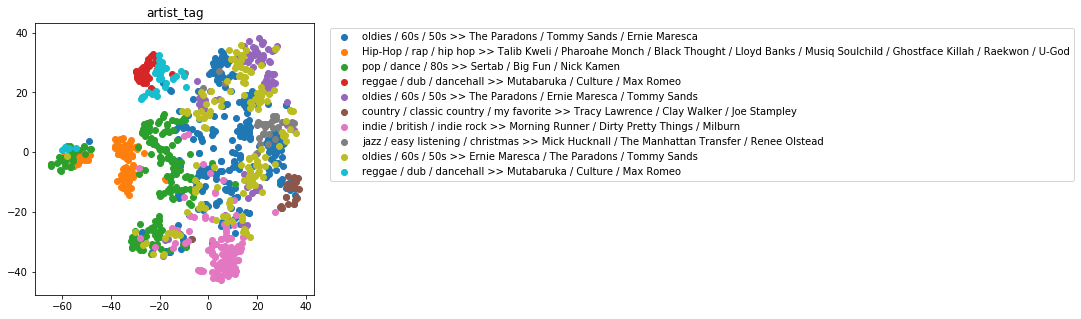

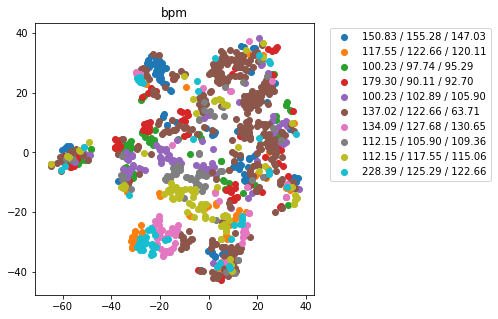

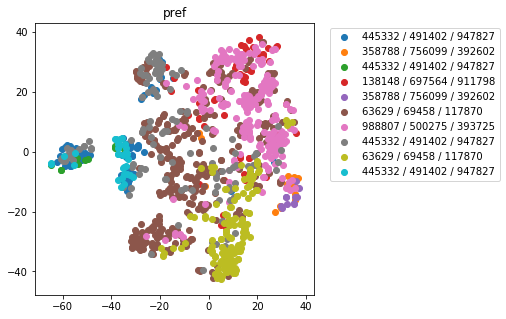

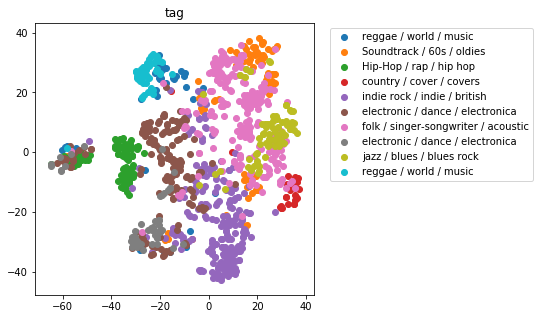

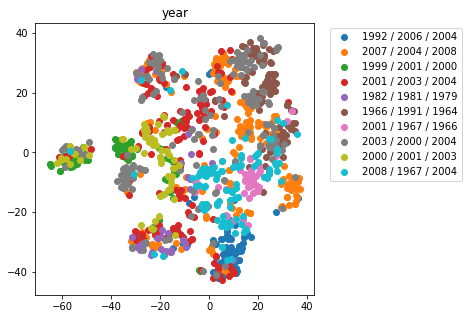

In [143]:
K = 10
top_terms = 3
top_terms_topic = 10
top_artist = 3
for k, v in hf['Z'].iteritems():
    print
    print
    print 'processing...', k
    kms = KMeans(n_clusters=K)
    if 'fc' in hf['X']:
        l = kms.fit_predict(hf['X']['fc'][:])
    else:
        l = kms.fit_predict(v)
    fig = plt.figure(figsize=(5,5))
    
    # get cluster term histogram
    for l_ in set(l):
        ix = np.where(l==l_)[0]
        z = hf['Z'][k][ix.tolist()]
        if k != 'bpm' and k != 'year':            
            # just pick strongest topic and display top 1 or 2 topic terms
            topic = np.argsort(np.bincount(np.argmax(z, axis=1)))[-1]
            if k == 'artist_tag':
                # for artist, we also find a few artists closest to the centroid
                label = ' / '.join([str(tt) for tt in topic_terms[k][topic][:top_terms]])
                artists_list = np.argsort(np.mean(z.dot(factors.T), axis=0))[::-1][:top_artist]
                label += ' >> ' + ' / '.join([artists[aa] for aa in artists_list])

            else:
                if k == 'cdr_tag':
                    label = ' / '.join([unicode(tt, errors='ignore') for tt in topic_terms[k][topic][:top_terms]])
                else:
                    label = ' / '.join([str(tt) for tt in topic_terms[k][topic][:top_terms]])
            
        else:
            topic = np.argsort(np.bincount(np.argmax(z, axis=1)))[-3:]
            if k == 'bpm':
                label= ' / '.join(['{:.2f}'.format(float(topic_terms[k][tt])) for tt in topic])
            elif k == 'year':
                label= ' / '.join(['{:d}'.format(int(topic_terms[k][tt])) for tt in topic])
    
        plt.scatter(x[ix, 0], x[ix, 1], label=label)
    plt.title(k)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")